# COVID-19 Beta



In [28]:
from datetime import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

plt.style.use("seaborn-deep")

## COVID-19 Data

We will use this NY Times [github repo](https://github.com/nytimes/covid-19-data) as the source of our COVID-19 Data (US only). One key problem with this dataset is that they retroactively fix datapoints, meaning that this data is not what we would have observed at the time. This limits the out-of-sample validity of this investigation.

We will use COVID cases and deaths as two separate "factors".

In [29]:
# Covid data
covid = pd.read_csv("nytimes_us_data.csv", parse_dates=["date"], index_col="date")
covid.head()

,cases,deaths
date,,
2020-01-21,1,0
2020-01-22,1,0
2020-01-23,1,0
2020-01-24,2,0
2020-01-25,3,0


In [30]:
def dual_plot(series1, series2, label1="1", label2="2", color1="darkblue", color2="darkred", figsize=(9,6)):
    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.set_ylabel(label1, color=color1)
    series1.plot(ax=ax1, color=color1)
    ax1.tick_params(axis="y", labelcolor=color1)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel(label2, color=color2)  # we already handled the x-label with ax1
    series2.plot(ax=ax2, color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped


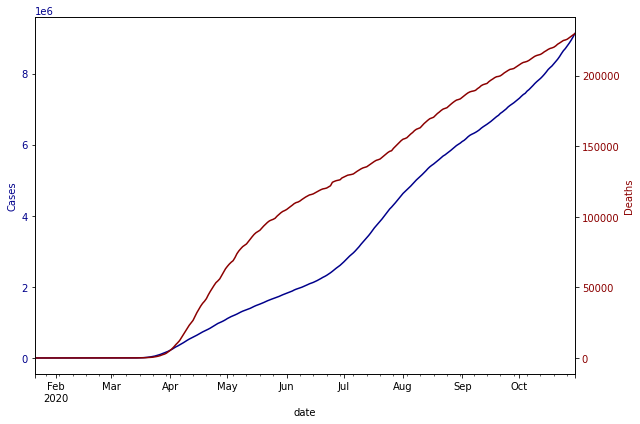

In [31]:
dual_plot(covid.cases, covid.deaths, "Cases", "Deaths")
plt.show()

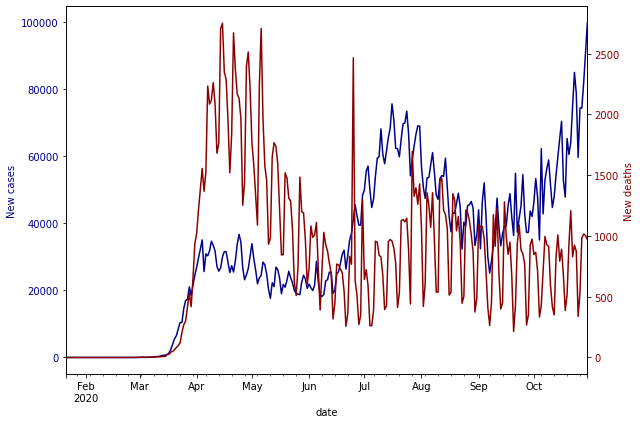

In [32]:
dual_plot(covid.cases.diff(), covid.deaths.diff(), "New cases", "New deaths")
plt.show()

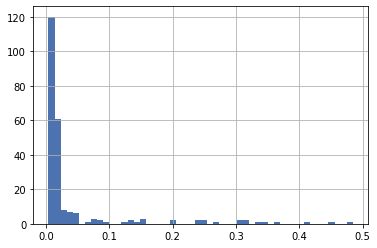

In [33]:
covid.cases.iloc[50:].pct_change().hist(bins=50);

## Asset prices

We will be computing the beta of S&P500 constituents to each COVID factor (cases and deaths"). In other words, we regress the asset returns to the daily percentage change in COVID.

We get the SPY constituents from [here](https://github.com/datasets/s-and-p-500-companies-financials) then use yfinance to pull historical YTD adjusted closes.

In [34]:
df = pd.read_csv("spy_constituents.csv")
tickers = df.Symbol.tolist()
df.head()

,Symbol,Name,Sector,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book,SEC Filings
0,MMM,3M Company,Industrials,222.89,24.31,2.332862,7.92,259.77,175.490,138721055226,9.048000e+09,4.390271,11.34,http://www.sec.gov/cgi-bin/browse-edgar?action...
1,AOS,A.O. Smith Corp,Industrials,60.24,27.76,1.147959,1.70,68.39,48.925,10783419933,6.010000e+08,3.575483,6.35,http://www.sec.gov/cgi-bin/browse-edgar?action...
2,ABT,Abbott Laboratories,Health Care,56.27,22.51,1.908982,0.26,64.60,42.280,102121042306,5.744000e+09,3.740480,3.19,http://www.sec.gov/cgi-bin/browse-edgar?action...
3,ABBV,AbbVie Inc.,Health Care,108.48,19.41,2.499560,3.29,125.86,60.050,181386347059,1.031000e+10,6.291571,26.14,http://www.sec.gov/cgi-bin/browse-edgar?action...
4,ACN,Accenture plc,Information Technology,150.51,25.47,1.714470,5.44,162.60,114.820,98765855553,5.643228e+09,2.604117,10.62,http://www.sec.gov/cgi-bin/browse-edgar?action...


In [35]:
# price_df = yf.download(tickers, period="ytd")["Adj Close"]
# price_df.to_csv("stock_prices.csv")

In [36]:
price_df = pd.read_csv("stock_prices.csv", parse_dates=["Date"], index_col="Date")
# Drop cols with missing
price_df = price_df.dropna(how="any", axis=1)
price_df.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,85.398193,28.982893,158.154831,74.573036,84.852608,83.938957,168.809998,85.600449,206.829712,334.429993,...,100.399811,67.240555,56.502354,35.372929,79.031929,100.691872,148.258896,259.140015,50.968010,133.375900
2020-01-03,84.027046,27.548195,158.164749,73.848030,84.047203,82.883308,166.820007,84.556908,206.485229,331.809998,...,98.088585,66.699974,55.877087,34.913166,79.497108,100.376495,147.871353,256.049988,50.248787,133.395782
2020-01-06,84.275452,27.219410,155.565384,74.436470,84.710480,84.096809,179.039993,84.999916,205.136902,333.709991,...,96.044044,67.212105,56.184761,34.386356,78.982445,100.317375,147.016785,258.010010,49.636467,132.371658
2020-01-07,84.533775,27.119778,153.720047,74.086395,84.227234,83.494980,180.350006,84.527367,200.707962,333.390015,...,98.236748,66.662033,56.482506,34.434250,78.685516,100.494774,146.887604,256.470001,49.335167,132.819077
2020-01-08,85.368385,27.737495,151.954056,75.278160,84.824188,84.303986,178.690002,84.871948,201.101685,337.869995,...,97.960182,65.656754,57.077999,34.415089,78.952736,100.672165,148.646439,247.639999,49.821129,132.530716


In [37]:
# spy_df = yf.download("^GSPC", period="ytd")["Adj Close"]
# spy_df.to_csv("spy_prices.csv")
spy_df = (
    pd.read_csv("spy_prices.csv", parse_dates=["Date"], index_col="Date")
    .rename({"Adj Close":"SPY"}, axis=1)
)
spy_df.head()

,SPY
Date,
2020-01-02,3257.850098
2020-01-03,3234.850098
2020-01-06,3246.280029
2020-01-07,3237.179932
2020-01-08,3253.050049


## Computing betas

In [38]:
joined = price_df.join(covid, how="inner").join(spy_df, how="inner")
tickerlist = joined.columns[:-3]
joined.iloc[20:]

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS,cases,deaths,SPY
2020-02-19,84.802040,28.330000,139.016724,80.541367,90.406998,94.267532,167.899994,88.346695,213.330124,383.279999,...,35.219673,87.058846,104.132797,159.010651,240.500000,44.853638,143.446472,25,0,3386.149902
2020-02-20,83.798531,28.510000,141.358139,79.715088,90.493431,95.654846,168.080002,87.456902,211.334335,378.959991,...,35.229252,87.751678,102.826073,157.390930,242.720001,45.284451,142.938660,27,0,3373.229980
2020-02-21,84.523842,27.820000,139.502869,77.910744,91.194481,96.120583,166.740005,86.458351,209.348465,372.950012,...,34.807800,87.613098,102.469681,156.397232,238.389999,44.481567,141.624268,30,0,3337.750000
2020-02-24,79.983185,25.450001,138.808395,74.209946,89.446648,94.069351,165.289993,83.670326,201.908783,357.410004,...,33.390205,85.544518,99.242447,153.356537,227.399994,42.846432,137.800613,43,0,3225.889893
2020-02-25,77.449554,23.120001,136.516586,71.696297,85.643684,92.087479,158.800003,80.210014,194.735870,347.799988,...,34.922745,83.466026,96.965561,148.785553,220.000000,41.495243,134.245834,45,0,3128.209961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-26,104.629997,11.800000,151.210007,115.050003,83.919998,98.370003,288.320007,109.000000,219.229996,475.200012,...,18.920000,90.070000,99.199997,139.509995,295.100006,32.459999,160.479996,8777118,225698,3400.969971
2020-10-27,106.040001,11.230000,150.410004,116.599998,82.709999,97.650002,290.510010,108.580002,220.660004,478.559998,...,18.520000,89.059998,97.989998,138.600006,289.279999,31.080000,162.470001,8851546,226681,3390.679932
2020-10-28,101.660004,10.950000,146.380005,111.199997,80.489998,95.699997,283.000000,106.419998,213.940002,456.970001,...,17.230000,87.349998,95.059998,133.369995,285.200012,30.600000,158.690002,8933448,227697,3271.030029
2020-10-29,102.019997,11.160000,146.000000,115.320000,80.669998,94.589996,254.610001,105.000000,216.440002,461.109985,...,17.650000,86.860001,94.940002,133.839996,291.970001,31.559999,161.190002,9024176,228701,3310.110107


In [39]:
# Regression approach
from sklearn import linear_model

rets = joined.pct_change().dropna()
betas = {}

for ticker in tickerlist:
    try:
        reg = linear_model.LinearRegression()
        reg.fit(rets[["cases", "SPY"]],rets[ticker])
        betas[ticker] = reg.coef_
    except:
        print(ticker)
    


In [40]:
betas = pd.DataFrame(betas, index=["cases_beta", "SPY_beta"]).transpose()

In [41]:
df_merged = df.merge(betas, left_on="Symbol", right_index=True, how="inner")
df_merged.head()

,Symbol,Name,Sector,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book,SEC Filings,cases_beta,SPY_beta
0,MMM,3M Company,Industrials,222.89,24.31,2.332862,7.92,259.77,175.490,138721055226,9.048000e+09,4.390271,11.34,http://www.sec.gov/cgi-bin/browse-edgar?action...,-0.001437,0.840696
1,AOS,A.O. Smith Corp,Industrials,60.24,27.76,1.147959,1.70,68.39,48.925,10783419933,6.010000e+08,3.575483,6.35,http://www.sec.gov/cgi-bin/browse-edgar?action...,0.013047,0.718005
2,ABT,Abbott Laboratories,Health Care,56.27,22.51,1.908982,0.26,64.60,42.280,102121042306,5.744000e+09,3.740480,3.19,http://www.sec.gov/cgi-bin/browse-edgar?action...,-0.002372,0.855342
3,ABBV,AbbVie Inc.,Health Care,108.48,19.41,2.499560,3.29,125.86,60.050,181386347059,1.031000e+10,6.291571,26.14,http://www.sec.gov/cgi-bin/browse-edgar?action...,-0.011371,0.681354
4,ACN,Accenture plc,Information Technology,150.51,25.47,1.714470,5.44,162.60,114.820,98765855553,5.643228e+09,2.604117,10.62,http://www.sec.gov/cgi-bin/browse-edgar?action...,0.005272,1.051471


## Data analysis

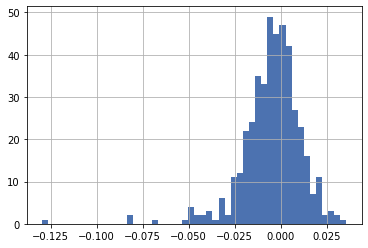

In [42]:
df_merged.cases_beta.hist(bins=50);

In [43]:
# Worst hit
df_merged.sort_values(by="cases_beta").iloc[:10]

,Symbol,Name,Sector,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book,SEC Filings,cases_beta,SPY_beta
49,APA,Apache Corporation,Energy,37.73,-251.53,2.528445,-3.72,57.90,38.140,15066280977,3.265000e+09,3.651366,2.22,http://www.sec.gov/cgi-bin/browse-edgar?action...,-0.129761,1.671640
346,OXY,Occidental Petroleum,Energy,68.47,195.63,4.408186,-0.75,78.09,57.200,53467692395,5.205000e+09,6.044895,NaN,http://www.sec.gov/cgi-bin/browse-edgar?action...,-0.082103,1.638488
292,MRO,Marathon Oil Corp.,Energy,15.68,-32.00,1.224740,-2.65,19.52,10.550,13875005314,2.266000e+09,4.657875,NaN,http://www.sec.gov/cgi-bin/browse-edgar?action...,-0.081550,1.264306
348,OKE,ONEOK,Energy,54.40,34.00,5.443620,1.66,61.36,47.140,21988472489,1.851783e+09,2.615956,4.03,http://www.sec.gov/cgi-bin/browse-edgar?action...,-0.069308,1.493620
205,GPS,Gap Inc.,Consumer Discretionary,31.17,15.35,2.820356,1.69,35.68,21.020,12684517721,1.959000e+09,1.128974,3.93,http://www.sec.gov/cgi-bin/browse-edgar?action...,-0.051908,1.439469
430,TPR,"Tapestry, Inc.",Consumer Discretionary,48.85,NaN,0.000000,2.09,50.71,36.690,14247199374,0.000000e+00,4.078549,4.35,http://www.sec.gov/cgi-bin/browse-edgar?action...,-0.048289,1.583849
229,HES,Hess Corporation,Energy,43.00,-9.33,2.267060,-19.94,55.48,37.250,14016129999,-8.190000e+08,3.780475,1.08,http://www.sec.gov/cgi-bin/browse-edgar?action...,-0.048166,1.361802
272,KSS,Kohl's Corp.,Consumer Discretionary,60.34,16.01,3.496504,3.12,69.14,35.160,10570861198,2.286000e+09,0.855776,2.04,http://www.sec.gov/cgi-bin/browse-edgar?action...,-0.047111,1.400060
219,HAL,Halliburton Co.,Energy,47.41,38.86,1.448984,-0.53,57.86,38.181,43356557470,2.910000e+09,2.142422,4.74,http://www.sec.gov/cgi-bin/browse-edgar?action...,-0.047069,1.762542
406,SLB,Schlumberger Ltd.,Energy,67.40,44.93,2.867383,-1.08,82.71,61.020,96529311126,3.222000e+09,3.229783,2.64,http://www.sec.gov/cgi-bin/browse-edgar?action...,-0.043947,1.383478


In [44]:
# Biggest beneficiaries
df_merged.sort_values(by="cases_beta").iloc[-10:]

,Symbol,Name,Sector,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book,SEC Filings,cases_beta,SPY_beta
480,WMT,Wal-Mart Stores,Consumer Staples,100.02,23.10,1.983471,4.39,109.98,66.8900,304680931618,3.072100e+10,0.820994,3.89,http://www.sec.gov/cgi-bin/browse-edgar?action...,0.021276,0.553764
326,NFLX,Netflix Inc.,Information Technology,250.10,200.08,0.000000,1.25,286.81,138.2600,114805404842,8.090280e+08,9.861594,30.80,http://www.sec.gov/cgi-bin/browse-edgar?action...,0.021827,0.693140
224,HAS,Hasbro Inc.,Consumer Discretionary,96.48,20.57,2.230483,4.34,116.20,87.9200,12732072001,1.028425e+09,3.237568,5.82,http://www.sec.gov/cgi-bin/browse-edgar?action...,0.023042,1.103237
309,MCHP,Microchip Technology,Information Technology,79.90,21.77,1.751297,0.66,99.17,69.7600,19393095636,9.974920e+08,7.447518,5.90,http://www.sec.gov/cgi-bin/browse-edgar?action...,0.023712,1.478947
195,FLIR,FLIR Systems,Information Technology,46.46,25.53,1.239669,1.21,52.88,33.7500,6706992926,3.752670e+08,5.137961,3.52,http://www.sec.gov/cgi-bin/browse-edgar?action...,0.026065,0.746490
151,DLTR,Dollar Tree,Consumer Discretionary,101.58,26.66,0.000000,3.77,116.65,65.6300,25151198417,2.430300e+09,1.609759,4.08,http://www.sec.gov/cgi-bin/browse-edgar?action...,0.027059,0.789291
85,COG,Cabot Oil & Gas,Energy,23.01,60.55,1.026958,-0.92,29.57,21.4000,10808821635,4.049510e+08,8.636729,4.21,http://www.sec.gov/cgi-bin/browse-edgar?action...,0.027165,0.819988
247,INTC,Intel Corp.,Information Technology,42.75,12.32,2.654867,1.98,50.85,33.2300,211536000000,2.624700e+10,3.348876,3.34,http://www.sec.gov/cgi-bin/browse-edgar?action...,0.029219,1.210357
271,KLAC,KLA-Tencor Corp.,Information Technology,98.54,16.59,2.298850,5.88,121.65,86.3300,16078622033,1.506642e+09,4.339586,12.93,http://www.sec.gov/cgi-bin/browse-edgar?action...,0.029483,1.512150
116,CTXS,Citrix Systems,Information Technology,84.53,20.37,0.000000,-0.24,95.00,73.3346,13199167493,8.102680e+08,4.753871,6.73,http://www.sec.gov/cgi-bin/browse-edgar?action...,0.035770,0.606636


In [45]:
# We remove left-tail outliers so that the visualisations are smoother
df_merged = df_merged[df_merged.cases_beta > df_merged.cases_beta.quantile(0.01)].sort_values(by="cases_beta")

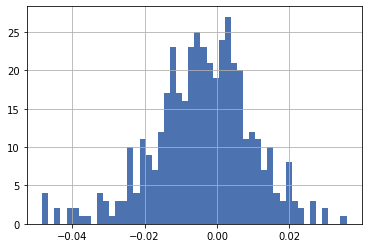

In [46]:
df_merged.cases_beta.hist(bins=50);

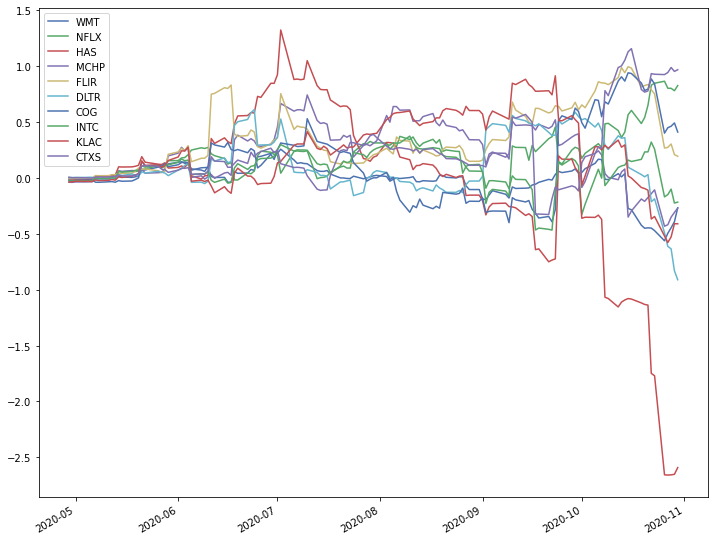

In [47]:
# Plot top 10 rolling betas
fig, ax = plt.subplots(figsize=(12,10))
top_10_tickers = df_merged.sort_values(by="cases_beta").Symbol.iloc[-10:].tolist()

res = []
period = 42 # 2months

for t in top_10_tickers:
    rolling_beta = (rets[t].rolling(period).cov(rets["cases"]) / rets["cases"].rolling(period).var()).dropna()
    res.append(rolling_beta.rename(t))
rolling_betas_top = pd.concat(res, axis=1)
rolling_betas_top.plot(ax=ax)
plt.show()

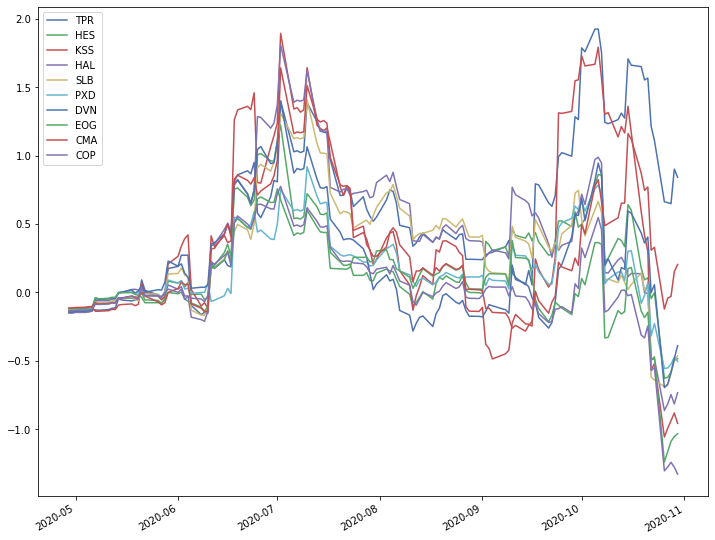

In [48]:
# Plot bottom 10 rolling betas
fig, ax = plt.subplots(figsize=(12,10))
bottom_10_tickers = df_merged.sort_values(by="cases_beta").Symbol.iloc[:10].tolist()

res = []
period = 42

for t in bottom_10_tickers:
    rolling_beta = (rets[t].rolling(period).cov(rets["cases"]) / rets["cases"].rolling(period).var()).dropna()
    res.append(rolling_beta.rename(t))
rolling_betas_bottom = pd.concat(res, axis=1)
rolling_betas_bottom.plot(ax=ax)
plt.show()

In [49]:
%%time
tickers = df_merged.Symbol.tolist()

res = []
period = 42

for t in tickers:
    rolling_beta = (rets[t].rolling(period).cov(rets["cases"]) / rets["cases"].rolling(period).var()).dropna()
    res.append(rolling_beta.rename(t))
rolling_betas = pd.concat(res, axis=1)
rolling_betas.head()

CPU times: user 2.01 s, sys: 15.1 ms, total: 2.02 s
Wall time: 2.1 s


,TPR,HES,KSS,HAL,SLB,PXD,DVN,EOG,CMA,COP,...,WMT,NFLX,HAS,MCHP,FLIR,DLTR,COG,INTC,KLAC,CTXS
2020-04-29,-0.141542,-0.147661,-0.118860,-0.151279,-0.127507,-0.133896,-0.144089,-0.119827,-0.113624,-0.133211,...,0.000157,-0.004685,-0.015986,-0.038913,-0.007183,0.003676,-0.020941,-0.026791,-0.036798,0.005927
2020-04-30,-0.136429,-0.149648,-0.115174,-0.151404,-0.126885,-0.135944,-0.144759,-0.120457,-0.114509,-0.135368,...,-0.004109,-0.007841,-0.018013,-0.039732,-0.006118,0.003301,-0.025394,-0.028327,-0.034919,0.001030
2020-05-01,-0.136229,-0.142607,-0.112129,-0.146815,-0.122646,-0.130923,-0.137546,-0.115720,-0.111297,-0.130121,...,-0.005028,-0.007532,-0.015888,-0.036249,-0.006147,0.004339,-0.020762,-0.026149,-0.030154,0.001905
2020-05-04,-0.134264,-0.143388,-0.111393,-0.146807,-0.123393,-0.130120,-0.137593,-0.117197,-0.109616,-0.130529,...,-0.005293,-0.008875,-0.016116,-0.036372,-0.004748,0.004236,-0.020259,-0.026419,-0.030508,0.000929
2020-05-05,-0.131100,-0.140488,-0.107637,-0.143489,-0.121543,-0.127640,-0.134782,-0.114522,-0.105738,-0.129052,...,-0.005244,-0.007010,-0.013009,-0.035289,-0.003442,0.005626,-0.019598,-0.025701,-0.030529,-0.000674


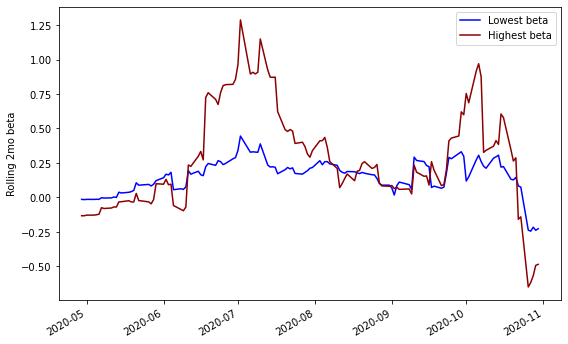

In [50]:
fig, ax = plt.subplots(figsize=(9,6))
rolling_betas_top.mean(axis=1).plot(ax=ax, color="blue", label="Lowest beta")
rolling_betas_bottom.mean(axis=1).plot(ax=ax, color="darkred", label="Highest beta")
ax.legend();
ax.set_ylabel("Rolling 2mo beta")
plt.savefig("rolling_beta.png", dpi=400)
# plt.show()

## Visualisation

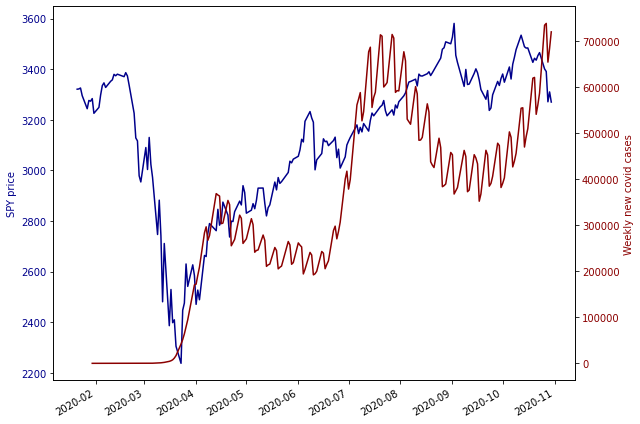

In [51]:
# COVID-19 and the SPY
dual_plot(joined.SPY, joined.cases.diff(7), "SPY price", "Weekly new covid cases")
# plt.savefig("spy_covid.png", dpi=400)
plt.show()

In [53]:
import plotly.express as px
df_merged["S&P500"] = "S&P500" # dummy root node
df_merged = df_merged.rename({"cases_beta": "COVID beta"}, axis=1)
fig = px.treemap(df_merged, path=['S&P500', 'Sector', 'Symbol'], values='Market Cap',
                  color='COVID beta', hover_data=['Price/Earnings', 'Price/Sales', 'Price/Book'],
                  color_continuous_scale='RdBu',
                  color_continuous_midpoint=np.average(df_merged['COVID beta'], weights=df_merged['Market Cap'])
                )
fig.update_layout(margin=dict(l=0, r=0, t=20, b=0)),
fig.show()

In [54]:
# Export to HTML
fig.write_html("heatmap.html", include_plotlyjs="cdn", full_html=False)

In [26]:
# Hosting on Chart Studio
# import chart_studio
# import chart_studio.plotly as py
# # chart_studio.tools.set_credentials_file(username="", api_key="")
# chart_studio.tools.set_config_file(sharing='public')
# py.plot(fig, filename="COVID_beta", auto_open=True)

'https://plotly.com/~robertmartin8/5/'